In [284]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Loading Data

In [285]:
columns = ['area','perimeter','compactness','length_kernel','width_kernel','asymmetry_coeff','length_groove','target']

In [286]:
data = pd.read_excel('seeds_dataset.xlsx',header=None, names=columns)

In [287]:
data.head()

,area,perimeter,compactness,length_kernel,width_kernel,asymmetry_coeff,length_groove,target
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


In [288]:
data.describe()

,area,perimeter,compactness,length_kernel,width_kernel,asymmetry_coeff,length_groove,target
count,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000
mean,14.847524,14.559286,0.870999,5.628533,3.258605,3.700201,5.408071,2.000000
std,2.909699,1.305959,0.023629,0.443063,0.377714,1.503557,0.491480,0.818448
min,10.590000,12.410000,0.808100,4.899000,2.630000,0.765100,4.519000,1.000000
25%,12.270000,13.450000,0.856900,5.262250,2.944000,2.561500,5.045000,1.000000
50%,14.355000,14.320000,0.873450,5.523500,3.237000,3.599000,5.223000,2.000000
75%,17.305000,15.715000,0.887775,5.979750,3.561750,4.768750,5.877000,3.000000
max,21.180000,17.250000,0.918300,6.675000,4.033000,8.456000,6.550000,3.000000


In [289]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 8 columns):
area               210 non-null float64
perimeter          210 non-null float64
compactness        210 non-null float64
length_kernel      210 non-null float64
width_kernel       210 non-null float64
asymmetry_coeff    210 non-null float64
length_groove      210 non-null float64
target             210 non-null int64
dtypes: float64(7), int64(1)
memory usage: 13.2 KB


### Data Visualization

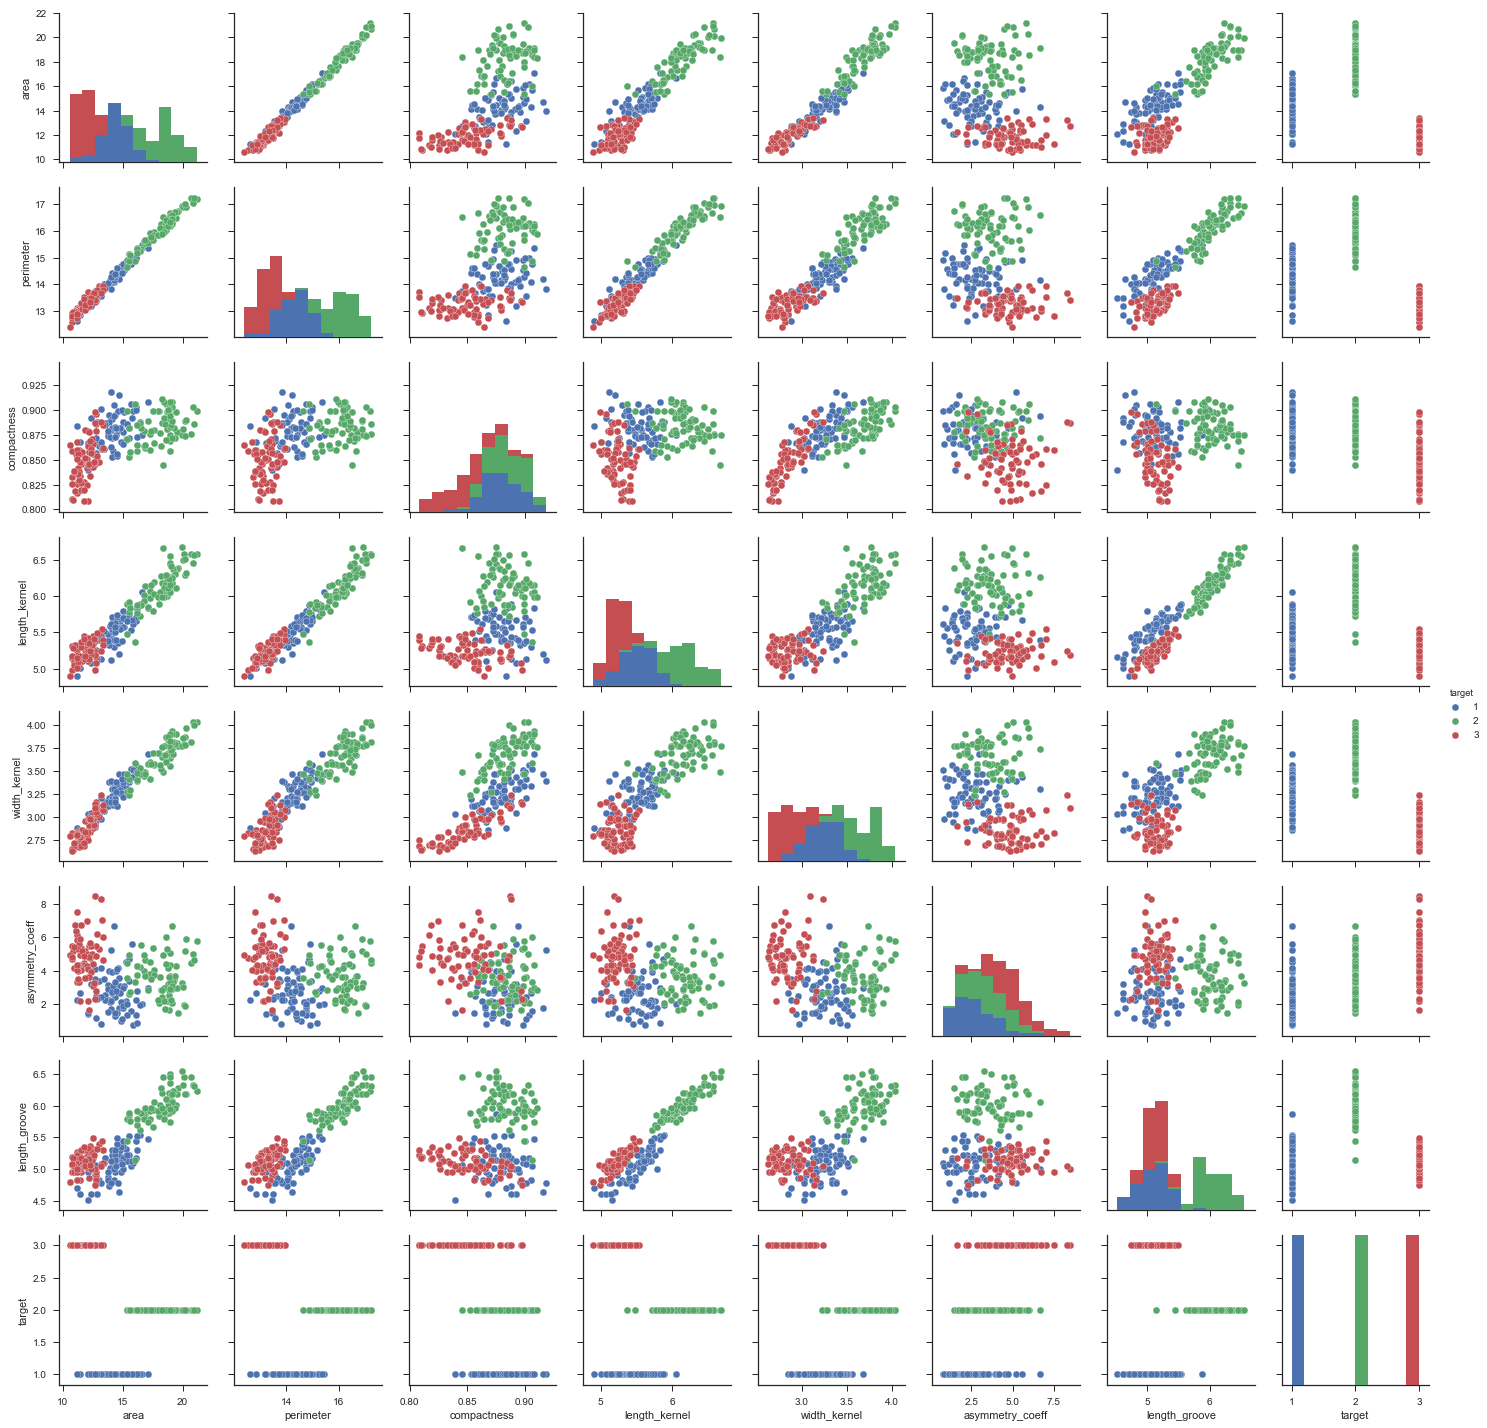

In [290]:
sns.set(style="ticks")
sns.pairplot(data,hue='target')

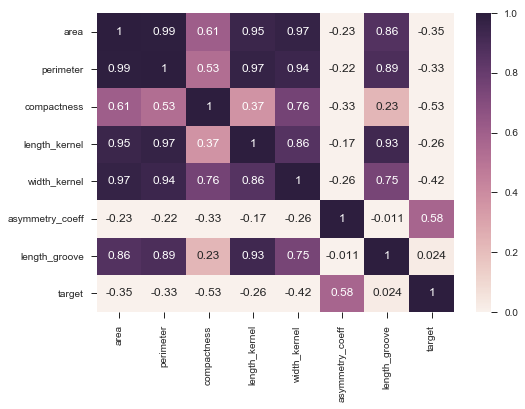

In [291]:
sns.heatmap(data.corr(),vmin=0,vmax=1,annot=True)

We can observe from above scatterplots that assymetric coefficient is quite high for Canadian seeds(Class=3) and other parameters(like area, width,length,etc) are quite small for Canadian seeds. From correlation heatmap we can also noticethat area, parameter, length and width are highly correlated

## Applying ML Algo for prediction

In [300]:
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC,SVC
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.preprocessing import MinMaxScaler

In [293]:
# splitting into input data and output data
X = data.drop(['target'],axis=1)
Y = data['target']

In [294]:
#preprocessing data as area and perimeter has quite high values and needs to be normalized(0-1)
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [295]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

In [296]:
#KNN
knnmodel = KNeighborsClassifier()
knnmodel.fit(X_train,Y_train)
pred = knnmodel.predict(X_test)
f1_score(Y_test,pred,average='micro')

0.88095238095238093

In [297]:
# Logistic Regression CV
logregmodel = LogisticRegressionCV(Cs=[0.01,0.1,1,10],solver='sag',n_jobs=-1)
logregmodel.fit(X_train,Y_train)
pred = logregmodel.predict(X_test)
f1_score(Y_test,pred,average='micro')

0.90476190476190477

In [298]:
#SVC
Cs = [0.01,0.1,1,10]
f1_scores = []
for C in Cs:
    svcmodel = SVC(C=C)
    svcmodel.fit(X_train,Y_train)
    pred= svcmodel.predict(X_test)
    f1_scores.append((f1_score(Y_test,pred,average='micro')))
max(f1_scores)

0.88095238095238093

In [304]:
#Gradient Boosting
learning_rate = [0.01,0.1,1]
f1_scores = []
preds = []
for lr in learning_rate:
    gbmodel = GradientBoostingClassifier(learning_rate=lr)
    gbmodel.fit(X_train,Y_train)
    pred = gbmodel.predict(X_test)
    preds.append(pred)
    f1_scores.append((f1_score(Y_test,pred,average='micro')))
f1_scores

[0.95238095238095233, 0.9285714285714286, 0.88095238095238093]

In [306]:
#Confusion matrix on Gradient boosting model 
#Cij denotes actual observations in Y_test vs predicted observations.(C00 denotes actual class=0,predicted=0)
confusion_matrix(Y_test,preds[0])

array([[11,  0,  0],
       [ 1, 13,  0],
       [ 1,  0, 16]])

### Conclusion:
Metrics : F1 Score (It calculates harmonic mean of both recall and precision)
Reason to choose F1 Score : F1 Score gives you good estimate where you don't want much false positive as well as false negative

First I chose logistic regression model as from scatter plot , it was understood that data can be classified linearly and I got decent accuracy of 90.4%
I moved on to SVM with rbf kernel but it was overfitting the data and accuracy was down to 88.09%
Finally, boosting algorithm outperformed both models achieving 95.24% accuracy.

From Confusion Matrix, we can show that our model has wrongly classified two samples (actual class=1 predicted 0 and actual class=2 predicted 0)

NOTE : I have prescaled data to normalize between 0-1 (using minmaxscaler)